<img src="https://docs.google.com/uc?id=1_8T8NAlzpyhk_M_hydFntzc3ajFxrGHO" />
<center>
    <h1>
        Creating a model to detect COVID-19 in X-ray
    </h1>
</center>

This notebook has the proposal to create a model that provides a primary diagnostics for COVID-19 through X-ray images.

_the methods and techniques used in this file are only for __educational purpose___

# Solution steps

    -- C1. Loading and shuffling the data
        -- Sample of X-ray images from pacients tested positive for COVID-19
        -- Sample of X-ray images from healthy patients (normal)
    -- C2. Data wrangling
        -- 1. Normalize to datagen
        -- 2. Transform target into keras binary
        -- 3. Splitting into training and test dataset
        -- 4. Data augmentation in the train set
    -- C3. Configuring transfer learning with VGG19  
    -- C4. Create and training the CNN model
    -- C5. Evaluate the model
    
# Solution proposal
    -- A ML classification model that provides COVID-19 diagnosis from chest X-ray images
    -- A Streamlit application to make the predictions

## 1.0 Imports

In [81]:
import os
import numpy as np
from PIL import Image
from collections import Counter

from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [61]:
# data visualization
import seaborn as sns
from matplotlib import pyplot as plt

# data visualization config
from IPython.core.pylabtools import figsize
%matplotlib inline
sns.set(figsize(18, 8))
sns.set(font_scale=1.35)

# C1. Loading and shuffling the data

In [2]:
def transform_img(file_path):
    img = Image.open(file_path)
    img = img.convert('RGB').resize((150,150))
    return np.asarray(img)

In [3]:
directory = {
    'normal': './data/normal',
    'covid-19': './data/covid-19'
}

In [4]:
images = []
labels = []
for label, dir_ in directory.items():
    files = os.listdir(dir_)
    for file in files:
        images.append(transform_img(f'{dir_}/{file}'))
        labels.append(label)   

In [5]:
Counter(labels)

Counter({'normal': 64, 'covid-19': 64})

# C2. Data wrangling

### 1. Normalize to datagen

In [6]:
# normalize to datagen
images = np.array(images) / 255

### 2. Transform target into keras binary

In [7]:
target = list(map(lambda x: 0 if x == 'normal' else 1, labels))
target = to_categorical(target)

### 3. Splitting into training and test dataset

In [8]:
# X, y = shuffle(images, target, random_state=2102)
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.25, random_state=2102)

### 4. Data augmentation in the train set

In [9]:
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2)
datagen.fit(X_train)
X_train_aug = datagen.flow(X_train, y_train)

## C3. Configuring transfer learning with VGG19

In [10]:
input_shape  = (150, 150, 3) # shape image
vgg_net = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

In [11]:
# retraining the bootm layers of VGG19
for layer in vgg_net.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
vgg_net.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# C4. Create and training the CNN model

### 1. Creating model layers

In [13]:
model = models.Sequential()
model.add(vgg_net)
model.add(layers.AveragePooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization()) # ADD / apply standardizes for model training
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(97, activation='relu'))
model.add(layers.Dropout(0.5)) # reduce overfitting
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 97)                198753    
_________________________________________________________________
dropout (Dropout)            (None, 97)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [14]:
#optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 2. Callback function

In [15]:
lr_plateau = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.07, 
    min_delta=1e-4, 
    patience=7, 
    verbose=1, 
    mode='auto'
)

callbacks = [lr_plateau]

### 3. Model training

In [16]:
epochs = 100
batch_size = 27

H = model.fit(X_train_aug,
                steps_per_epoch = int(len(X_train)/batch_size),
                validation_data = (X_test, y_test),
                validation_steps = int(len(X_test)/batch_size),
                callbacks = callbacks,
                epochs=epochs)

Epoch 1/100
3/3 [==============================] - 8s 3s/step - loss: 0.4625 - accuracy: 0.8021 - val_loss: 1.1608 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 8s 3s/step - loss: 0.3129 - accuracy: 0.8646 - val_loss: 6.7100 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 9s 3s/step - loss: 0.3247 - accuracy: 0.8646 - val_loss: 4.8321 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 9s 3s/step - loss: 0.1092 - accuracy: 0.9479 - val_loss: 6.7100 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 9s 3s/step - loss: 0.1967 - accuracy: 0.9479 - val_loss: 6.7100 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 9s 3s/step - loss: 0.0658 - accuracy: 0.9792 - val_loss: 5.6269 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 9s 3s/step - loss: 0.2361 - accuracy: 0.885

Epoch 50/100
3/3 [==============================] - 9s 3s/step - loss: 0.0549 - accuracy: 0.9896 - val_loss: 0.1369 - val_accuracy: 0.9375 - lr: 2.4010e-08
Epoch 51/100
3/3 [==============================] - 9s 3s/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.1290 - val_accuracy: 0.9375 - lr: 2.4010e-08
Epoch 52/100
3/3 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 1.0000  
Epoch 00052: ReduceLROnPlateau reducing learning rate to 1.6807000768892524e-09.
3/3 [==============================] - 9s 3s/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1216 - val_accuracy: 0.9375 - lr: 2.4010e-08
Epoch 53/100
3/3 [==============================] - 9s 3s/step - loss: 0.1185 - accuracy: 0.9583 - val_loss: 0.1136 - val_accuracy: 0.9688 - lr: 1.6807e-09
Epoch 54/100
3/3 [==============================] - 9s 3s/step - loss: 0.1757 - accuracy: 0.9583 - val_loss: 0.1086 - val_accuracy: 0.9688 - lr: 1.6807e-09
Epoch 55/100
3/3 [==============================] - 9s 3

3/3 [==============================] - 9s 3s/step - loss: 0.0817 - accuracy: 0.9792 - val_loss: 0.0228 - val_accuracy: 1.0000 - lr: 2.8248e-15
Epoch 97/100
3/3 [==============================] - 9s 3s/step - loss: 0.0728 - accuracy: 0.9688 - val_loss: 0.0223 - val_accuracy: 1.0000 - lr: 2.8248e-15
Epoch 98/100
3/3 [==============================] - 9s 3s/step - loss: 0.0313 - accuracy: 0.9896 - val_loss: 0.0219 - val_accuracy: 1.0000 - lr: 2.8248e-15
Epoch 99/100
3/3 [==============================] - 9s 3s/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 1.0000 - lr: 2.8248e-15
Epoch 100/100
3/3 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9792
Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.977326671674532e-16.
3/3 [==============================] - 9s 3s/step - loss: 0.0589 - accuracy: 0.9792 - val_loss: 0.0209 - val_accuracy: 1.0000 - lr: 2.8248e-15


# C5. Evaluate the model

### 1. Model metrics

In [83]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis=1)

y_true = y_test.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



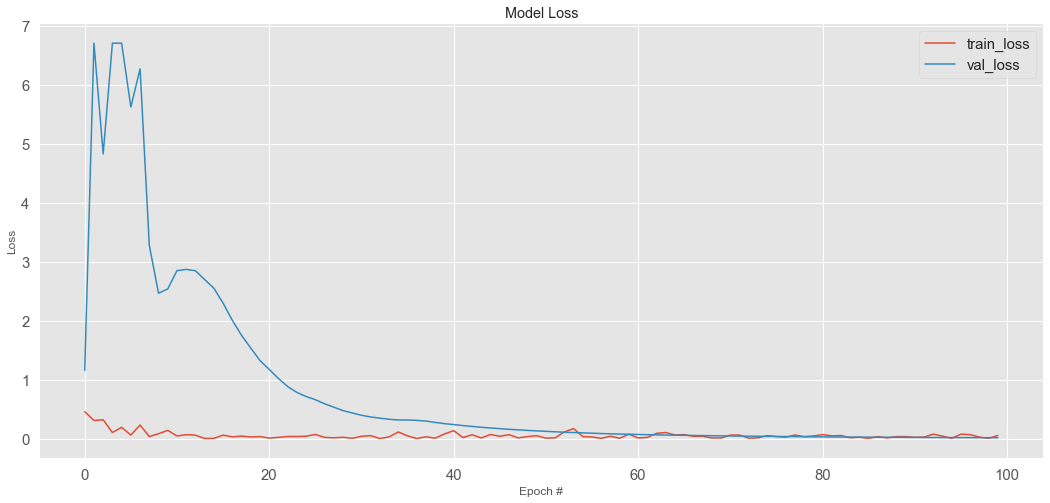

In [77]:
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Model Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right");

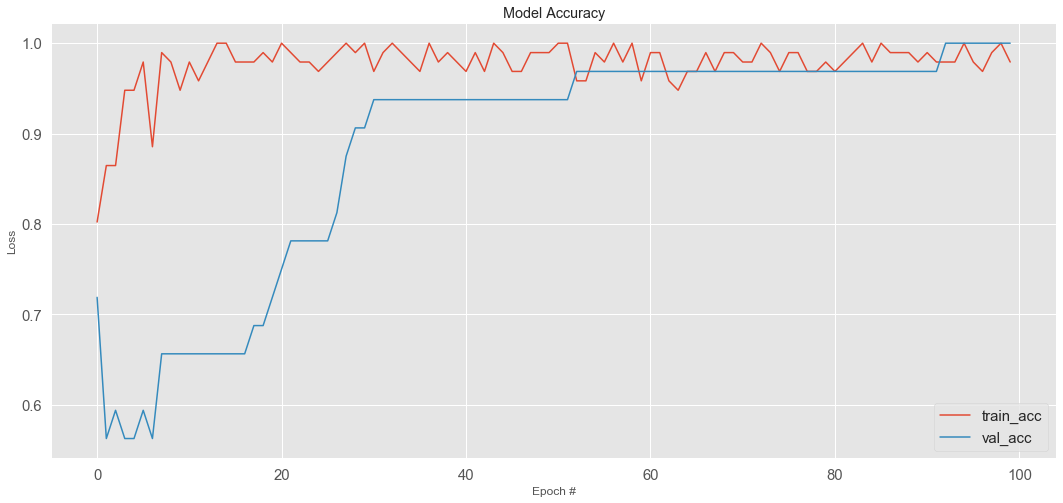

In [80]:
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower right");

### 2. Confusion matrix

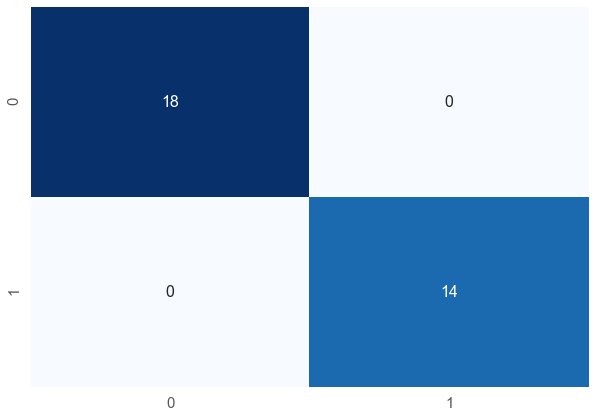

In [128]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, cbar=False);

# Exports model

In [140]:
from tensorflow import keras
model.save('./ml-models/model-covid-100-exp.h5')